In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import glicko2

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [61]:
np.random.seed(47)

In [6]:
# data_2017 = pd.read_excel('lol_2017.xlsx')
# games_2017 = data_2017[['gameid','league','week','game','side','team','result','date']]
# games_2017 = games_2017.drop_duplicates()
# games_2017.reset_index(drop = True, inplace = True)
# games_2017 = games_2017.merge(games_2017, on = ['gameid','league'], suffixes = ['_1','_2'])
# games_2017 = games_2017[(games_2017['result_1']==1)&(games_2017['team_1']!=games_2017['team_2'])]
# games_2017 = games_2017.reset_index(drop = True)
# games_2017.drop(games_2017[games_2017['league'] == 'LPL'].index, inplace = True)
# games_2017.reset_index(inplace = True, drop = True)
# #

In [7]:
# data_2018 = pd.concat([pd.read_excel('lol_2018_spring.xlsx'),pd.read_excel('lol_2018_summer.xlsx')], axis = 1)

In [8]:
# pd.read_excel('lol_2018_spring.xlsx').head()

In [9]:
# import datetime as dt
# games_2017['date_1'] = pd.to_datetime(games_2017['date_1']).dt.date

# Data prep 

In [10]:
# eu_2017 = games_2017[games_2017['league'] == 'EULCS']

In [11]:
bets_2017 = pd.read_excel('lol_bets.xlsx')
bets_2017['date'] = pd.to_datetime(bets_2017['date'])

In [12]:
start_eu_teams = ['Splyce',
 'Fnatic',
 'Misfits',
 'Roccat',
 'G2 Esports',
 'Unicorns of Love',
 'Vitality',
 'Origen',
 'H2k-Gaming',
 'Giants Gaming']

In [13]:
start_na_teams = ['Team Liquid',
 'Dignitas',
 'Cloud9',
 'Counter Logic Gaming',
 'Immortals',
 'Phoenix1',
 'Echo Fox',
 'Team Solomid',
 'Team EnVyUs',
 'FlyQuest eSports']

In [14]:
bets_2017['week'] = bets_2017.date.dt.week
bets_2017['week'] = bets_2017['week'] - bets_2017['week'].min() + 1
bets_2017['week'] = bets_2017['week'].rank(method = 'dense').astype(int)
bets_2017.sort_values('date', inplace = True)

In [15]:
bets_2017.loc[bets_2017[bets_2017['date']<='2017-04-16'].index,'split'] = 1
bets_2017.loc[bets_2017[bets_2017['date']>'2017-04-16'].index,'split'] = 2

In [16]:
bets_2018 = pd.read_excel('lol_bets_2018.xlsx')

In [17]:
bets_2018.columns = ['team_1','team_2','odd_1','odd_2','date']

In [18]:
bets_2018['week'] = bets_2018.date.dt.week
bets_2018['week'] = bets_2018['week'] - bets_2018['week'].min() + 1
bets_2018['week'] = bets_2018['week'].rank(method = 'dense').astype(int)+ bets_2017.week.max()
bets_2018.sort_values('date', inplace = True)

In [19]:
bets_2018.loc[bets_2018[bets_2018['date']<'2018-06-01'].index,'split'] = 3
bets_2018.loc[bets_2018[bets_2018['date']>'2018-06-01'].index,'split'] = 4

In [20]:
bets = pd.concat([bets_2017,bets_2018] )

In [21]:
total_eu_teams = list(bets[bets['team_1'] == 'Fnatic'].team_2.unique()) + ['Fnatic']
total_na_teams = list(bets[bets['team_1'] == 'Cloud9'].team_2.unique()) + ['Cloud9']

In [22]:
eu_bets = bets[(bets.team_1.isin(total_eu_teams)) | (bets.team_2.isin(total_eu_teams))]
na_bets = bets[(bets.team_1.isin(total_na_teams)) | (bets.team_2.isin(total_na_teams))]

# ELO BETS

In [195]:
from elosports import elo
eloLeague = elo.Elo(k = 20, homefield=0)

In [204]:
def train_elo(teams, num_weeks, data, k):
    eloLeague = elo.Elo(k = k, homefield=0)
    for team in teams:
        eloLeague.addPlayer(team)
    
    train = data[data['week'].isin(np.arange(1,num_weeks+1))]
    for i, row in train.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']
        if team1 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team1)
            eloLeague.ratingDict[team1] = np.mean(list(eloLeague.ratingDict.values()))

        if team2 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team2)
            eloLeague.ratingDict[team2] = np.mean(list(eloLeague.ratingDict.values()))
    
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return eloLeague

In [205]:
def elo_betting(eloLeague,num_weeks ,data, threshold):
    dollars = 100
    wins = 0
    losses = 0
    ddt = []
    wr_dt = []
    test = data[~data['week'].isin(np.arange(num_weeks,2*num_weeks+1))]
    for i, row in test.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']

        if team1 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team1)
            eloLeague.ratingDict[team1] = np.mean(list(eloLeague.ratingDict.values()))

        if team2 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team2)
            eloLeague.ratingDict[team2] = np.mean(list(eloLeague.ratingDict.values()))

        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1
        
        prob = eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2])
        
        if prob > 0.5:
            winner = team1
        else:
            winner = team2
        
        if bet>0:        
            if winner == team1:
                wins +=1
                if prob >threshold or prob<1-threshold:
                    dollars += 5*bet - 5
#     - 5
            else:
                losses +=1
                if prob >threshold or prob<1-threshold:
                    dollars -= 5
                
        else:
            if winner == team1:
                wins+=1
            else:
                losses += 1
                
                
        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return dollars,wins,losses,ddt,wr_dt

In [206]:
def elo_eval(eloLeague ,data, threshold):
    dollars = 100
    wins = 0
    losses = 0
    ddt = []
    wr_dt = []
    probs = []
    test = data[data['week'].isin(np.arange(0,200))]
    for i, row in test.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']

        if team1 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team1)
            eloLeague.ratingDict[team1] = np.mean(list(eloLeague.ratingDict.values()))

        if team2 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team2)
            eloLeague.ratingDict[team2] = np.mean(list(eloLeague.ratingDict.values()))

        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1
        
        prob = eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2])
        
        if prob >= 0.5:
            winner = team1
        else:
            winner = team2
        
        probs.append(prob)
        
        if bet>0:        
            if winner == team1:
                wins +=1
                if prob >threshold or prob<1-threshold:
                    dollars += 5*bet - 5
#     - 5
            else:
#                 probs.append(prob)
                losses +=1
                if prob >threshold or prob<1-threshold:
                    dollars -= 5
                
        else:
            if winner == team1:
                wins+=1
            else:
                losses += 1

        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return dollars,wins,losses,ddt,wr_dt,probs

In [393]:
dollars_elo = [0]
wins_elo = []
losses_elo = []
precision = []
best_k_elo = 0
best_games_elo = 0


for k in range(1, 100):
    eloLeague = train_elo(start_na_teams, 5.5, na_bets, k)
    dollars, wins, losses, ddt_elo,wr_dt_elo = elo_betting(eloLeague, 5.5, na_bets, 0.75)
    dollars_elo.append(dollars)
    wins_elo.append(wins)
    losses_elo.append(losses)
    if dollars > max(dollars_elo[:-1]):
        best_k_elo = k
    precision.append(wins/(losses + wins))

In [394]:
best_k_elo

23

In [460]:
eloLeague = train_elo(start_na_teams, 20, na_bets[na_bets.split.isin([1])], best_k_elo)
dollars, wins, losses, ddt_elo_graph,wr_dt_elo_graph, probs = elo_eval(eloLeague, na_bets[na_bets.split.isin([2,3,4])],0.75)



[]

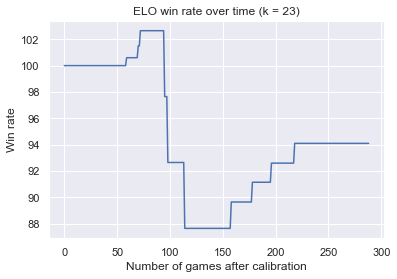

In [461]:
plt.plot(ddt_elo_graph)
plt.xlabel('Number of games after calibration')
plt.ylabel('Win rate')
plt.title('ELO win rate over time (k = {})'.format(best_k_elo))
plt.plot()

In [399]:
wins, losses, wins/(wins+losses), dollars

(171, 118, 0.5916955017301038, 94.10000000000001)

[]

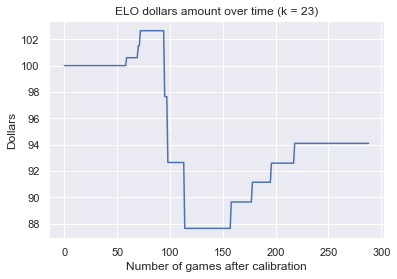

In [401]:
plt.plot(ddt_elo_graph)
plt.xlabel('Number of games after calibration')
plt.ylabel('Dollars')
plt.title('ELO dollars amount over time (k = {})'.format(best_k_elo))
plt.plot()

In [404]:
eloLeague = train_elo(start_na_teams, 20, na_bets[na_bets.split.isin([1])], best_k_elo)
dollars, wins, losses, ddt_elo,wr_dt_elo,_ = elo_eval(eloLeague, na_bets[na_bets.split.isin([2])],0.75)



In [405]:
pd.DataFrame.from_dict(eloLeague.ratingDict,orient='index').to_clipboard()

# Bets Trueskill

In [406]:
import trueskill

In [407]:
env = trueskill.TrueSkill(draw_probability=0)

In [408]:
init_skills = [trueskill.Rating() for team in start_eu_teams]

In [409]:
na_teams_skills = dict(zip(start_na_teams,init_skills))

In [410]:
import itertools
import math
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (trueskill.BETA * trueskill.BETA) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)

In [411]:
def train_trueskill(teams, num_weeks, data):
#     env = trueskill.TrueSkill(draw_probability=0,tau = tau, beta = tau*100/2, sigma = tau*100)

    init_skills = [trueskill.Rating() for team in teams]
    eu_teams_skills = dict(zip(teams,init_skills))
    
    train = data[data['week'].isin(np.arange(1,num_weeks+1))]

    for i, row in train.iterrows():
        team1, team2 = row['team_1'],row['team_2']
        avg_mean = np.mean([val.mu for val in list(eu_teams_skills.values())])
        avg_sigma = np.mean([val.sigma for val in list(eu_teams_skills.values())])

        if team1 not in eu_teams_skills.keys():
            eu_teams_skills[team1] = trueskill.Rating()
            eu_teams_skills[team1].mu = avg_mean
            eu_teams_skills[team1].sigma = avg_sigma

        if team2 not in eu_teams_skills.keys():
            eu_teams_skills[team1] = trueskill.Rating()
            eu_teams_skills[team2].mu = avg_mean
            eu_teams_skills[team2].sigma = avg_sigma

        eu_teams_skills[team1],eu_teams_skills[team2] = trueskill.rate_1vs1(eu_teams_skills[team1],eu_teams_skills[team2], env = env)
    return eu_teams_skills

In [412]:
def trueskill_betting(eu_teams_skills, num_weeks, data,threshold):
#     env = trueskill.TrueSkill(draw_probability=0, tau = tau, beta = tau*100/2, sigma = tau*100)
    dollars = 100
    wins = 0
    losses = 0
    ddt = []
    wr_dt = []
    test = data[data['week'].isin(np.arange(num_weeks,num_weeks*2+1))]
    for i, row in test.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']
        
        avg_mean = np.mean([val.mu for val in list(eu_teams_skills.values())])
        avg_sigma = np.mean([val.sigma for val in list(eu_teams_skills.values())])

        if team1 not in eu_teams_skills.keys():
            eu_teams_skills[team1] = trueskill.Rating(avg_mean, avg_sigma)

        if team2 not in eu_teams_skills.keys():
            eu_teams_skills[team2] = trueskill.Rating(avg_mean, avg_sigma)

        
        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1
        
        prob = win_probability([eu_teams_skills[team1]],[eu_teams_skills[team2]])
        
        if prob > 0.5:
            winner = team1
        else:
            winner = team2
            
            
        if bet>0:        
            if winner == team1:
                wins +=1
                if prob > threshold or prob < 1 - threshold:
                    dollars += 5*bet - 5 
            else:
                if prob > threshold or prob < 1 - threshold:
                    dollars -= 5
                losses +=1
        else:
            if winner == team1:
                wins+=1
            else:
                losses += 1
        
        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))

        eu_teams_skills[team1],eu_teams_skills[team2] = trueskill.rate_1vs1(eu_teams_skills[team1],eu_teams_skills[team2], env = env)

    return dollars,wins,losses,ddt,wr_dt

In [413]:
def trueskill_eval(eu_teams_skills, data, threshold):
#     env = trueskill.TrueSkill(draw_probability=0, tau = tau, beta = tau*100/2, sigma = tau*100)
    dollars = 100
    wins = 0
    losses = 0
    ddt = []
    wr_dt = []
    test = data[data['week'].isin(np.arange(0,100))]
    for i, row in test.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']
        
        avg_mean = np.mean([val.mu for val in list(eu_teams_skills.values())])
        avg_sigma = np.mean([val.sigma for val in list(eu_teams_skills.values())])

        if team1 not in eu_teams_skills.keys():
            eu_teams_skills[team1] = trueskill.Rating(avg_mean, avg_sigma)

        if team2 not in eu_teams_skills.keys():
            eu_teams_skills[team2] = trueskill.Rating(avg_mean, avg_sigma)


        
        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1
        
        
        prob = win_probability([eu_teams_skills[team1]],[eu_teams_skills[team2]])
        
        if prob > 0.5:
            winner = team1
        else:
            winner = team2
            
            
        if bet>0:        
            if winner == team1:
                wins +=1
                if prob > threshold or prob < 1 - threshold:
                    dollars += 5*bet - 5
            else:
                if prob > threshold or prob < 1 - threshold:
                    dollars -= 5
                losses +=1
        else:
            if winner == team1:
                wins+=1
            else:
                losses += 1
                
        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))

        eu_teams_skills[team1],eu_teams_skills[team2] = trueskill.rate_1vs1(eu_teams_skills[team1],eu_teams_skills[team2], env = env)

    return dollars,wins,losses,ddt,wr_dt

In [414]:
dollars_trueskill = [0]
wins_trueskill = []
losses_trueskill = []
precision_trueskill = []
best_tau_trueskill = 0
best_sigma_trueskill = 0
best_beta_trueskill = 0


for beta in np.arange(1.0,5.0):
#             env = trueskill.TrueSkill(draw_probability=0,tau = tau, beta = tau*100/2, sigma = tau*100)
    env = trueskill.TrueSkill(draw_probability=0,tau = 1, beta = 0.5)
    env.make_as_global()
    na_teams_skills = train_trueskill(start_na_teams, 5.5, na_bets)
    dollars, wins, losses,ddt_ts,wr_dt_ts = trueskill_betting(na_teams_skills, 5.5, na_bets,0.75)
    dollars_trueskill.append(dollars)
    wins_trueskill.append(wins)
    losses_trueskill.append(losses)
    precision_trueskill.append(wins/(losses + wins))
    if dollars > max(dollars_trueskill[:-1]):
#         best_tau_trueskill = tau
#         best_sigma_trueskill = sigma
        best_beta_trueskill = beta


In [417]:
env = trueskill.TrueSkill(draw_probability=0, beta = best_beta_trueskill)
env.make_as_global()

na_teams_skills = train_trueskill(start_na_teams, 20, na_bets[na_bets.split.isin([1])])
dollars, wins, losses,ddt_ts_graph,wr_dt_ts_graph = trueskill_eval(na_teams_skills,  na_bets[na_bets.split.isin([2,3,4])], 0.75)



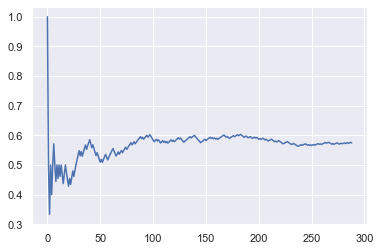

In [418]:
plt.plot(wr_dt_ts_graph)

In [419]:
pd.DataFrame.from_dict(na_teams_skills, orient = 'index').to_clipboard()

[]

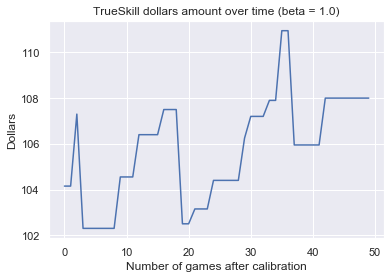

In [420]:
plt.plot(ddt_ts)
plt.xlabel('Number of games after calibration')
plt.ylabel('Dollars')
plt.title('TrueSkill dollars amount over time (beta = {})'.format(best_beta_trueskill))
plt.plot()

[]

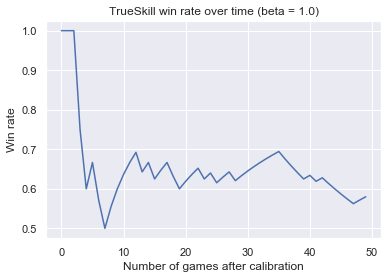

In [421]:
plt.plot(wr_dt_ts)
plt.xlabel('Number of games after calibration')
plt.ylabel('Win rate')
plt.title('TrueSkill win rate over time (beta = {})'.format(best_beta_trueskill))
plt.plot()

In [422]:
(wins, losses, wins/(wins+losses), dollars)

(166, 123, 0.5743944636678201, 95)

In [432]:
na_teams_skills = train_trueskill(start_na_teams, 20, na_bets[na_bets.split.isin([1])])
dollars, wins, losses,ddt_ts,wr_dt_ts = trueskill_eval(na_teams_skills,  na_bets[na_bets.split.isin([2,3,4])], 0.75)


In [434]:
# pd.Series([k for k in na_teams_skills.keys()]).to_clipboard()
pd.Series([v.mu for v in na_teams_skills.values()]).to_clipboard()

# Glicko2 betting

In [310]:
import glicko2

In [316]:
def train_glicko(teams, num_weeks, data, phi):
    g2 = glicko2.Glicko2(tau = tau, phi = phi)
    init_skills_glicko = [g2.create_rating() for team in teams]
    eu_teams_glicko = dict(zip(teams,init_skills_glicko))
    
    train = data[data['week'].isin(np.arange(1,num_weeks+1))]

    for i, row in train.iterrows():
        team_1, team_2 = row['team_1'],row['team_2']
        avg_mean = np.mean([val.mu for val in list(eu_teams_glicko.values())])
        avg_phi = np.mean([val.phi for val in list(eu_teams_glicko.values())])

        if team_1 not in eu_teams_glicko.keys():
            eu_teams_glicko[team_1] = g2.create_rating(mu = avg_mean, phi = avg_phi)

        if team_2 not in eu_teams_glicko.keys():
            eu_teams_glicko[team_2] = g2.create_rating(mu = avg_mean, phi = avg_phi)

        eu_teams_glicko[team_1],eu_teams_glicko[team_2] = g2.rate_1vs1(eu_teams_glicko[team_1],eu_teams_glicko[team_2])
    return eu_teams_glicko


In [334]:
def glicko_betting(eu_teams_glicko, num_weeks ,data, phi,threshold):
    dollars = 100
    wins = 0
    losses = 0
    test = data[data['week'].isin(np.arange(num_weeks,num_weeks*2+1))]
    ddt = []
    wr_dt = []
    
    g2 = glicko2.Glicko2(phi = phi)
    
    for i, row in test.iterrows():
        team_1 = row['team_1']
        team_2 = row['team_2']
        
        avg_mean = np.mean([val.mu for val in list(eu_teams_glicko.values())])
        avg_phi = np.mean([val.phi for val in list(eu_teams_glicko.values())])
        
        if team_1 not in eu_teams_glicko.keys():
            eu_teams_glicko[team_1] = g2.create_rating(mu = avg_mean, phi = avg_phi)

        if team_2 not in eu_teams_glicko.keys():
            eu_teams_glicko[team_2] = g2.create_rating(mu = avg_mean, phi = avg_phi)

        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1

        prob = g2.expect_score(eu_teams_glicko[team_1],eu_teams_glicko[team_2],g2.reduce_impact(eu_teams_glicko[team_1]))
            
        if prob  > 0.5:
            winner = team_1
        else:
            winner = team_2
            
        if bet>0:        
            if winner == team_1:
                if prob > threshold or prob < 1 - threshold:
                    dollars += 5*bet -5 
                wins +=1
            else:
                if prob > threshold or prob < 1 - threshold:
                    dollars -= 5
                losses +=1
        else:
            if winner == team_1:
                wins+=1
            else:
                losses += 1
                
        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))

 
        eu_teams_glicko[team_1],eu_teams_glicko[team_2] = g2.rate_1vs1(eu_teams_glicko[team_1],eu_teams_glicko[team_2])


    return dollars,wins,losses,ddt,wr_dt

In [335]:
def glicko_eval(eu_teams_glicko, data, phi, threshold):
    dollars = 100
    wins = 0
    losses = 0
    test = data[data['week'].isin(np.arange(0,100))]
    ddt = [] 
    wr_dt = []
    
    g2 = glicko2.Glicko2(phi = phi)
    
    for i, row in test.iterrows():
        team_1 = row['team_1']
        team_2 = row['team_2']
        
        avg_mean = np.mean([val.mu for val in list(eu_teams_glicko.values())])
        avg_phi = np.mean([val.phi for val in list(eu_teams_glicko.values())])
        
        if team_1 not in eu_teams_glicko.keys():
            eu_teams_glicko[team_1] = g2.create_rating(mu = avg_mean, phi = avg_phi)

        if team_2 not in eu_teams_glicko.keys():
            eu_teams_glicko[team_2] = g2.create_rating(mu = avg_mean, phi = avg_phi)

        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1

        prob = g2.expect_score(eu_teams_glicko[team_1],eu_teams_glicko[team_2],g2.reduce_impact(eu_teams_glicko[team_1]))
            
        if prob  > 0.5:
            winner = team_1
        else:
            winner = team_2
            
        if bet>0:        
            if winner == team_1:
                if prob > threshold or prob < 1 - threshold:
                    dollars += 5*bet - 5
                wins +=1
            else:
                if prob > threshold or prob < 1 - threshold:
                    dollars -= 5
                losses +=1
        else:
            if winner == team_1:
                wins+=1
            else:
                losses += 1
                
        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))

 
        eu_teams_glicko[team_1],eu_teams_glicko[team_2] = g2.rate_1vs1(eu_teams_glicko[team_1],eu_teams_glicko[team_2])


    return dollars,wins,losses,ddt,wr_dt

In [487]:
na_bets

,date,team_1,team_2,odd_1,odd_2,week,split
2,2017-01-20,Cloud9,Team Solomid,2.18,1.61,1,1.0
1,2017-01-21,Phoenix1,Echo Fox,1.40,2.73,1,1.0
96,2017-01-21,Immortals,Echo Fox,1.24,3.64,1,1.0
17,2017-01-21,Team Liquid,Counter Logic Gaming,2.06,1.68,1,1.0
245,2017-01-22,Team Solomid,Immortals,1.46,2.54,1,1.0
...,...,...,...,...,...,...,...
2,2018-09-08,Team Solomid,100 Thieves,1.46,2.55,49,4.0
215,2018-09-09,Team Liquid,Cloud9,1.61,2.14,49,4.0
12,2018-09-14,Echo Fox,Clutch Gaming,1.28,3.38,50,4.0
13,2018-09-15,Team Solomid,Echo Fox,1.60,2.17,50,4.0


In [482]:
dollars_glicko = [0]
wins_glicko = []
losses_glicko = []
precision_glicko = []
best_tau = 0
best_phi = 0
tau = 1
ddt_g2= []
wr_dt_g2= []
for phi in np.arange(150,560,10):
    na_teams_glicko = train_glicko(start_na_teams, 5.5, na_bets, phi)
    dollars, wins, losses, ddt_g2, wr_dt_g2 = glicko_betting(na_teams_glicko, 5.5, na_bets,phi, 0.75)
    dollars_glicko.append(dollars)
    if dollars > max(dollars_glicko[:-1]):
        best_tau = tau
        best_phi = phi
#         print(dollars)
    wins_glicko.append(wins)
    losses_glicko.append(losses)
    precision_glicko.append(wins/(losses + wins))

    

In [483]:
na_teams_glicko = train_glicko(start_na_teams, 20, na_bets[na_bets.split.isin([1])],  best_phi)
dollars, wins, losses,ddt_g2_graph, wr_dt_g2_graph = glicko_eval(na_teams_glicko, na_bets[na_bets.split.isin([2,3,4])], best_phi, 0.75)



In [484]:
q = pd.DataFrame.from_dict(na_teams_glicko, orient = 'index')
q[0] = [v.mu for v in  na_teams_glicko.values()]
q.to_clipboard()
# q

[]

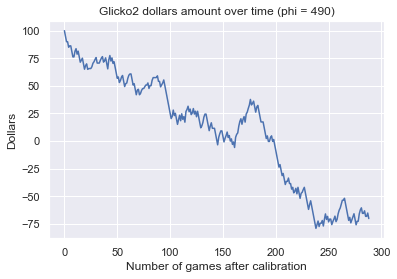

In [485]:
plt.plot(ddt_g2_graph)
plt.xlabel('Number of games after calibration')
plt.ylabel('Dollars')
plt.title('Glicko2 dollars amount over time (phi = {})'.format(best_phi))
plt.plot()

[]

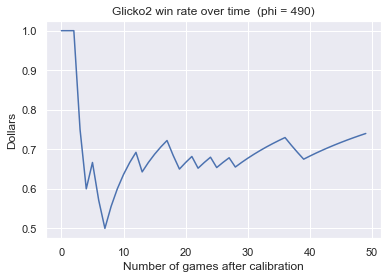

In [465]:
plt.plot(wr_dt_g2)
plt.xlabel('Number of games after calibration')
plt.ylabel('Dollars')
plt.title('Glicko2 win rate over time  (phi = {})'.format(best_phi))
plt.plot()

In [472]:
(wins,losses,wins/(wins+losses), dollars)

(165, 124, 0.5709342560553633, 499.75)

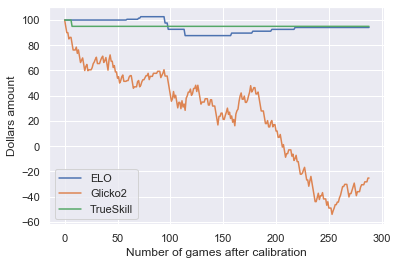

In [467]:
# plt.figure(figsize = (16,12))
plt.plot(ddt_elo_graph)
plt.plot(ddt_g2_graph)
plt.plot(ddt_ts_graph)
plt.legend(['ELO','Glicko2','TrueSkill'])
plt.xlabel('Number of games after calibration')
plt.ylabel('Dollars amount')
plt.show()

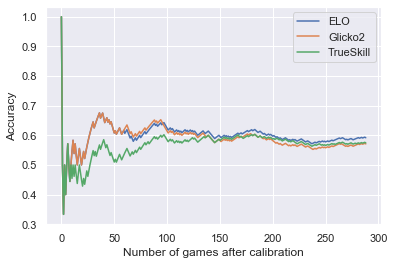

In [468]:
# plt.figure(figsize = (16,12))
plt.plot(wr_dt_elo_graph)
plt.plot(wr_dt_g2_graph)
plt.plot(wr_dt_ts_graph)
plt.legend(['ELO','Glicko2','TrueSkill'])
# plt.title('Accuracy over time')
plt.xlabel('Number of games after calibration')
plt.ylabel('Accuracy')
plt.show()

# END OF MAIN PART

In [ ]:
eu_bets['teams'] = (eu_bets['team_1'] + '~' + eu_bets['team_2']).str.split('~').apply(set).apply(sorted)
eu_bets['teams'] = eu_bets['teams'].apply(' '.join)

In [ ]:
eu_bets['prev_winner'] = eu_bets[['team_1','teams']].groupby('teams').shift()

In [ ]:
eu_bets [eu_bets['odd_1'] != '-']

In [ ]:
(eu_bets [(eu_bets['odd_1'] != '-') & (eu_bets['split'] >= '1.0')]['odd_1']<eu_bets [eu_bets['odd_1'] != '-']['odd_2']).value_counts()


In [ ]:
(eu_bets[(eu_bets['split'] != 1 ) & (eu_bets['odd_1'] != '-' )]['odd_1'] > eu_bets[(eu_bets['split'] != 1 ) & (eu_bets['odd_1'] != '-' )]['odd_2']).value_counts()


In [ ]:
164/(164+81)

In [ ]:
eu_bets['split']

In [ ]:
eloLeague.ratingDict['Splyce']

In [ ]:
eloLeague.expectResult(1555,1785)

In [ ]:
eloLeague.ratingDict

In [ ]:
def train_elo_new(teams, num_weeks, data, k):
    eloLeague = elo.Elo(k = k, homefield=0)
    for team in teams:
        eloLeague.addPlayer(team)
    
    train = data[data['week'].isin(np.arange(1,num_weeks+1))]
    for i, row in train.iterrows():
        prev_winner = row['prev_winner']
        team1 = row['team_1']
        team2 = row['team_2']
        if team1 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team1)
            eloLeague.ratingDict[team1] = np.mean(list(eloLeague.ratingDict.values()))

        if team2 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team2)
            eloLeague.ratingDict[team2] = np.mean(list(eloLeague.ratingDict.values()))
        

        
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return eloLeague

In [ ]:
def elo_betting_new(eloLeague,num_weeks ,data, const):
    dollars = 100
    wins = 0
    losses = 0
    ddt = []
    wr_dt = []
    test = data[data['week'].isin(np.arange(num_weeks,2*num_weeks+1))]
    for i, row in test.iterrows():
        prev_winner = row['prev_winner']
        team1 = row['team_1']
        team2 = row['team_2']

        if team1 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team1)
            eloLeague.ratingDict[team1] = np.mean(list(eloLeague.ratingDict.values()))

        if team2 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team2)
            eloLeague.ratingDict[team2] = np.mean(list(eloLeague.ratingDict.values()))

        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1

            
        if prev_winner == team1:
            if eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2]*const)>0.5:
                winner = team1
            else: winner = team2
        elif prev_winner == team2:
            if eloLeague.expectResult(eloLeague.ratingDict[team1]*const,eloLeague.ratingDict[team2])>0.5:
                winner = team1
            else: winner = team2
        else:            
            if eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2]) >= 0.5:
                winner = team1
            else:
                winner = team2
        
        if bet>0:        
            if winner == team1:
                dollars += 5*bet
                wins +=1
            else:
                dollars -= 5
                losses +=1
        else:
            if winner == team1:
                wins+=1
            else:
                losses += 1
        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return dollars,wins,losses,ddt,wr_dt

In [ ]:
def elo_eval_new(eloLeague ,data, const):
    dollars = 100
    wins = 0
    losses = 0
    ddt = []
    wr_dt = []
    q = []
    test = data[data['week'].isin(np.arange(0,100))]
    for i, row in test.iterrows():
        prev_winner = row['prev_winner']
        team1 = row['team_1']
        team2 = row['team_2']

        if team1 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team1)
            eloLeague.ratingDict[team1] = np.mean(list(eloLeague.ratingDict.values()))

        if team2 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team2)
            eloLeague.ratingDict[team2] = np.mean(list(eloLeague.ratingDict.values()))

        
        try :
            bet = float(row['odd_1'])
        except:
            bet = -1
        
        if prev_winner == team1:
            if eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2]*const)>0.5:
                winner = team1
            else: winner = team2
        elif prev_winner == team2:
            if eloLeague.expectResult(eloLeague.ratingDict[team1]*const,eloLeague.ratingDict[team2])>0.5:
                winner = team1
            else: winner = team2
        else:            
            if eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2]) >= 0.5:
                winner = team1
            else:
                winner = team2
        
        if bet>0:        
            if winner == team1:
                dollars += 5*bet
                wins +=1
            else:
                print(i)
                q.append(i)
                dollars -= 5
                losses +=1
        else:
            if winner == team1:
                wins+=1
            else:
                losses += 1
        ddt.append(dollars)
        wr_dt.append(wins/(wins+losses))
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return dollars,wins,losses,ddt,wr_dt,q

In [ ]:
eu2 = eu_bets.reset_index(drop = True)

In [ ]:
dollars_elo = [0]
wins_elo = []
losses_elo = []
precision = []
best_k_elo = 0
best_games_elo = 0


for k in range(66, 67):
    for const in np.arange(0.9,1.1,0.01):
        eloLeague = train_elo_new(start_eu_teams,5.5, eu2, k)
        dollars, wins, losses, ddt_elo,wr_dt_elo = elo_betting_new(eloLeague, 5.5, eu2, const = 1)
        dollars_elo.append(dollars)
        wins_elo.append(wins)
        losses_elo.append(losses)
        if dollars > max(dollars_elo[:-1]):
            best_k_elo = k
            best_const = const
        precision.append(wins/(losses + wins))

In [ ]:
best_const

In [ ]:
eloLeague = train_elo_new(start_eu_teams, 20, eu2[eu2.split.isin([1])], 66)
dollars, wins, losses, ddt_elo,wr_dt_elo,q = elo_eval_new(eloLeague, eu2[eu2.split.isin([2,3,4])], const = 1)




In [ ]:
eu2.loc[q]

In [ ]:
dollars, wins, losses

In [ ]:
plt.plot(ddt_elo)

In [ ]:
plt.plot(wr_dt_elo)

In [ ]:
data_2016 = pd.read_excel('lol_2016.xlsx')

In [ ]:
data_2017[['league','team']].groupby('league')['team'].unique().to_clipboard()

In [ ]:
data_2016.head()

In [ ]:
data = data_2016.copy()

In [ ]:
games = data[['gameid','league','week','game','side','team','result']]

In [ ]:
games = games.drop_duplicates()

In [ ]:
games.reset_index(drop = True, inplace = True)

In [ ]:
games = games.merge(games, on = ['gameid','league'], suffixes = ['_1','_2'])

In [ ]:
games = games[(games['result_1']==1)&(games['team_1']!=games['team_2'])]

In [ ]:
games = games.reset_index(drop = True)

In [ ]:
eu = games[games['league'] == 'EULCS']

In [ ]:
eu['team_1'].replace('Elements', 'Schalke 04', inplace = True)
eu['team_2'].replace('Elements', 'Schalke 04', inplace = True)

In [ ]:
eu_to_fit = eu[eu['week_1'].isin([1,2,3])]

In [ ]:
games = pd.read_excel('lol_bets.xlsx')

In [ ]:
eu_teams = list(data_2017[data_2017['league'] == 'EULCS']['team'].unique())
na_teams = list(data_2017[data_2017['league'] == 'NALCS']['team'].unique())

In [ ]:
eu_teams = eu_teams + ['H2k-Gaming','Giants Gaming']

In [ ]:
eu = games[games['team_1'].isin(eu_teams)]
na = games[games['team_1'].isin(na_teams)]

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data_2017[data_2017['league'] == 'EULCS'][['team','date']].drop_duplicates()

In [ ]:
(eu.sort_values('date').groupby('date').count()).tail(40)

In [ ]:
games.sort_values('date')

# ELO

In [ ]:
from elosports import elo
eloLeague = elo.Elo(k = 20, homefield=0)

In [ ]:
# eu = games[games['league'] == 'EULCS']
# eu['team_1'].replace('Elements', 'Schalke 04', inplace = True)
# eu['team_2'].replace('Elements', 'Schalke 04', inplace = True)

In [ ]:
def train_elo(teams, num_games, data, k):
    eloLeague = elo.Elo(k = k, homefield=0)
    for team in teams:
        eloLeague.addPlayer(team)
    
    train = data[data['week_1'].isin(np.arange(1,num_games+1))]
    for i, row in train.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']
        if team1 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team1)
            eloLeague.ratingDict[team1] = np.median(list(eloLeague.ratingDict.values()))

        if team2 not in eloLeague.ratingDict.keys():
            eloLeague.addPlayer(team2)
            eloLeague.ratingDict[team2] = np.median(list(eloLeague.ratingDict.values()))
    
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return eloLeague

In [ ]:
for i, row in eu_to_fit.iterrows():
    team1 = row['team_1']
    team2 = row['team_2']
    if team1 not in eloLeague.ratingDict.keys():
        eloLeague.addPlayer(team1)
        eloLeague.ratingDict[team1] = np.mean(list(eloLeague.ratingDict.values()))
        
    if team2 not in eloLeague.ratingDict.keys():
        eloLeague.addPlayer(team2)
        eloLeague.ratingDict[team2] = np.mean(list(eloLeague.ratingDict.values()))
    
    eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)

In [ ]:
eu_to_test = eu[~eu['week_1'].isin([1,2,3])]

In [ ]:
def elo_betting(eloLeague,num_games ,data):
    dollars = 100
    wins = 0
    losses = 0
    test = data[~data['week_1'].isin(np.arange(1,num_games+1))]
    for i, row in test.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']
        if eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2]) > 0.5:
            winner = team1
        else:
            winner = team2
        if winner == team1:
            dollars += 5*1.05
            wins +=1
        else:
            dollars -= 5
            losses +=1
        eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)
    return dollars,wins,losses

In [ ]:
elo_betting(eloLeague, 5,eu)

In [ ]:
dollars = 100
wins = 0
losses = 0
for i, row in eu_to_test.iterrows():
    team1 = row['team_1']
    team2 = row['team_2']
    if eloLeague.expectResult(eloLeague.ratingDict[team1],eloLeague.ratingDict[team2]) > 0.5:
        winner = team1
    else:
        winner = team2
    if winner == team1:
        dollars += 5*1.05
        wins +=1
    else:
        dollars -= 5
        losses +=1
    eloLeague.gameOver(winner = row['team_1'], loser = row['team_2'],winnerHome=0)

## Full ELO loop

In [ ]:
eloLeague = train_elo(eu_teams, 5, eu,3)
elo_betting(eloLeague, 5, eu)

## Elo experiments

In [ ]:
range(1,10)

In [ ]:
dollars_elo = []
wins_elo = []
losses_elo = []
precision = []

for k in range(1, 100):
    for games in np.arange(1,10):
        eloLeague = train_elo(eu_teams, games, eu,k)
        dollars, wins, losses = elo_betting(eloLeague, games, eu)
        dollars_elo.append(dollars)
        wins_elo.append(wins)
        losses_elo.append(losses)
        if dollars == max(dollars_elo):
            best_k = k
            best_games = games
        precision.append(wins/(losses + wins))

In [ ]:
best_k, best_games

In [ ]:
eloLeague = train_elo(eu_teams, 3, eu,11)
print(elo_betting(eloLeague, games, eu))

Best interations for precision: k = 11, games = 3
Best interations for dollars: k = 11, games = 2

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.plot(precision)

# Trueskill

In [ ]:
import trueskill

In [ ]:
eu_teams = list(eu['team_1'].unique())

In [ ]:
env = trueskill.TrueSkill(draw_probability=0)

In [ ]:
init_skills = [trueskill.Rating() for team in eu_teams]

In [ ]:
eu_teams_skills = dict(zip(eu_teams,init_skills))

In [ ]:
import itertools
import math
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (trueskill.BETA * trueskill.BETA) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)

In [ ]:
def train_trueskill(teams, num_games, data):
    env = trueskill.TrueSkill(draw_probability=0)
    init_skills = [trueskill.Rating() for team in eu_teams]
    eu_teams_skills = dict(zip(eu_teams,init_skills))
    
    train = data[data['week_1'].isin(np.arange(1,num_games+1))]
    print(len(train))

    for i, row in eu_to_fit.iterrows():
        team1, team2 = row['team_1'],row['team_2']
        avg_mean = np.mean([val.mu for val in list(eu_teams_skills.values())])
        avg_sigma = np.mean([val.sigma for val in list(eu_teams_skills.values())])

        if team1 not in eu_teams_skills.keys():
            eu_teams_skills[team1] = trueskill.Rating()
            eu_teams_skills[team1].mu = avg_mean
            eu_teams_skills[team1].sigma = avg_sigma

        if team2 not in eu_teams_skills.keys():
            eu_teams_skills[team1] = trueskill.Rating()
            eu_teams_skills[team2].mu = avg_mean
            eu_teams_skills[team2].sigma = avg_sigma

        eu_teams_skills[team1],eu_teams_skills[team2] = trueskill.rate_1vs1(eu_teams_skills[team1],eu_teams_skills[team2], env = env)
    return eu_teams_skills


In [ ]:
def trueskill_betting(eu_teams_skills, num_games ,data):
    dollars = 100
    wins = 0
    losses = 0
    test = data[~data['week_1'].isin(np.arange(1,num_games+1))]
    for i, row in eu_to_test.iterrows():
        team1 = row['team_1']
        team2 = row['team_2']

        if win_probability([eu_teams_skills[team1]],[eu_teams_skills[team2]]) > 0.5:
            winner = team1
        else:
            winner = team2
        if winner == team1:
            dollars += 5*1.05
            wins +=1
        else:
            dollars -= 5
            losses +=1

        eu_teams_skills[team1],eu_teams_skills[team2] = trueskill.rate_1vs1(eu_teams_skills[team1],eu_teams_skills[team2], env = env)

    return dollars,wins,losses

In [ ]:
eu_teams_skills = train_trueskill(eu_teams, 3, eu)

In [ ]:
trueskill_betting(eu_teams_skills,3, eu)

In [ ]:
dollars_trueskill = []
wins_trueskill = []
losses_trueskill = []
precision_trueskill = []
for games in np.arange(1,20):
    eu_teams_skills = train_trueskill(eu_teams, games, eu)
    dollars, wins, losses = trueskill_betting(eloLeague, games, eu)
    dollars_trueskill.append(dollars)
    wins_trueskill.append(wins)
    losses_trueskill.append(losses)
    precision_trueskill.append(wins/(losses + wins))

In [ ]:
plt.plot(precision_trueskill)

In [ ]:
for i, row in eu_to_fit.iterrows():
    team_1, team_2 = row['team_1'],row['team_2']
    avg_mean = np.mean([val.mu for val in list(eu_teams_skills.values())])
    avg_sigma = np.mean([val.sigma for val in list(eu_teams_skills.values())])
    
    if team1 not in eu_teams_skills.keys():
        eu_teams_skills[team1] = trueskill.Rating()
        eu_teams_skills[team1].mu = avg_mean
        eu_teams_skills[team1].sigma = avg_sigma
        
    if team2 not in eu_teams_skills.keys():
        eu_teams_skills[team1] = trueskill.Rating()
        eu_teams_skills[team2].mu = avg_mean
        eu_teams_skills[team2].sigma = avg_sigma
    
    eu_teams_skills[team_1],eu_teams_skills[team_2] = trueskill.rate_1vs1(eu_teams_skills[team_1],eu_teams_skills[team_2], env = env)

In [ ]:
avg_sigma

In [ ]:
eu_teams_skills

In [ ]:
eu_to_test

In [ ]:
win_probability([eu_teams_skills['Vitality']],[eu_teams_skills['Schalke 04']])

In [ ]:
team_2

In [ ]:
dollars = 100
wins = 0
losses = 0
for i, row in eu_to_test.iterrows():
    team1 = row['team_1']
    team2 = row['team_2']
    
    if win_probability([eu_teams_skills[team1]],[eu_teams_skills[team2]]) > 0.5:
        winner = team1
    else:
        winner = team2
    if winner == team1:
        dollars += 5*1.05
        wins +=1
    else:
        dollars -= 5
        losses +=1
    
    eu_teams_skills[team1],eu_teams_skills[team2] = trueskill.rate_1vs1(eu_teams_skills[team1],eu_teams_skills[team2], env = env)
    

In [ ]:
dollars

In [ ]:
avg_sigma

In [ ]:
eu_teams_skills

In [ ]:
eu_teams_skills_mean = {k: v.mu for k, v in sorted(eu_teams_skills.items(), key=lambda item: item[1])}


In [ ]:
eu_teams_skills_mean

In [ ]:
{k: v for k, v in sorted(eloLeague.ratingDict.items(), key=lambda item: item[1])}


# Glicko2

In [ ]:
from glicko2 import glicko2

In [ ]:
init_skills_glicko = [glicko2.Glicko2().create_rating() for team in eu_teams]

In [ ]:
eu_teams_glicko = dict(zip(eu_teams,init_skills_glicko))

In [ ]:
glicko2.Glicko2().rate_1vs1(eu_teams_glicko['Fnatic'],eu_teams_glicko['Vitality'])

In [ ]:
glicko2.Glicko2().expect_score(eu_teams_glicko['Fnatic'],eu_teams_glicko['Fnatic'],glicko2.Glicko2().reduce_impact(eu_teams_glicko['Fnatic'])) 



In [ ]:
for i, row in eu_to_fit.iterrows():
    team_1, team_2 = row['team_1'],row['team_2']
#     avg_mean = np.mean([val.mu for val in list(eu_teams_skills.values())])
#     avg_sigma = np.mean([val.sigma for val in list(eu_teams_skills.values())])
    
#     if team1 not in eu_teams_skills.keys():
#         eu_teams_skills[team1] = trueskill.Rating()
#         eu_teams_skills[team1].mu = avg_mean
#         eu_teams_skills[team1].sigma = avg_sigma
        
#     if team2 not in eu_teams_skills.keys():
#         eu_teams_skills[team1] = trueskill.Rating()
#         eu_teams_skills[team2].mu = avg_mean
#         eu_teams_skills[team2].sigma = avg_sigma
    eu_teams_glicko[team_1],eu_teams_glicko[team_2] = glicko2.Glicko2().rate_1vs1(eu_teams_glicko[team_1],eu_teams_glicko[team_2])
    

In [ ]:
dollars = 100
wins = 0
losses = 0
for i, row in eu_to_test.iterrows():
    team1 = row['team_1']
    team2 = row['team_2']
    

    if glicko2.Glicko2().expect_score(eu_teams_glicko[team1],eu_teams_glicko[team2],glicko2.Glicko2().reduce_impact(eu_teams_glicko[team1]))  > 0.5:
        winner = team1
    else:
        winner = team2
    if winner == team1:
        dollars += 5*1.05
        wins +=1
    else:
        dollars -= 5
        losses +=1
    
    eu_teams_glicko[team_1],eu_teams_glicko[team_2] = glicko2.Glicko2().rate_1vs1(eu_teams_glicko[team_1],eu_teams_glicko[team_2])
    

In [ ]:
dollars